In [1]:
import cv2
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

import scipy.stats as ss

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

from PIL import Image, ImageDraw, ImageFont
import PIL

import os

import copy
import random
import time

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('./data')

Drive already mounted at ./data; to attempt to forcibly remount, call drive.mount("./data", force_remount=True).


In [3]:
!cp /content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports/pre_train.py /content
!cp /content/data/MyDrive/ColabNotebooks/Doc_recognition/Passports/models.py /content

In [4]:
import pre_train as pt
from models import CNNModelOneConv, CNNModelTwoConv

In [5]:
PREFIX = "data/MyDrive/ColabNotebooks/Doc_recognition/Passports/"

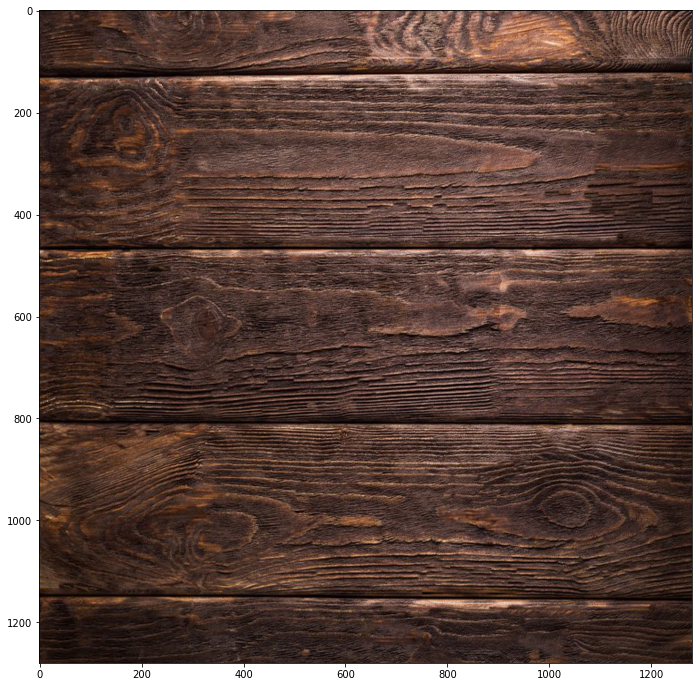

In [6]:
backgrounds = os.listdir(PREFIX + "photo_data/backgrounds")
backs = []

for bg in backgrounds:
    backs.append(PIL.Image.open(PREFIX + "photo_data/backgrounds/" + bg))
    size_0 = backs[-1].size

    backs[-1] = backs[-1].resize((size_0[0], size_0[0]))

ind = np.random.randint(len(backgrounds))
plt.figure(figsize=(12, 12))
plt.imshow(backs[ind])

## Есть всего 4 фона  
Надо обучить модель и посмотреть, зависит ли качество от фона. Аргументы следующие:
    - Фоны разных цветов. На каких-то паспорта видны очень хорошо за счёт контраста, на других же такого контраста нет.
    - Фонты-деревяшки имеют полоски, за которые модель в принципе может зацепиться.

In [7]:
images = os.listdir(PREFIX + "dataset/images")
np.random.shuffle(images)

RATIO = 0.9
train_inds = np.array([900])
valid_inds = np.array([901, 1000])

# Теперь попробуем что-нибудь обучить

## 2 convolution layers

In [8]:
Info = []
OUTPUT_DIM = 61
EPOCHS = 30

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
for i in range(0, 1):
    model = CNNModelTwoConv(OUTPUT_DIM)
    Info.append({"Loss": [], "L1": [], "Time": [], "Parameters": 0})
    Info[-1]["Parameters"] = pt.count_parameters(model)

    optimizer = optim.Adam(params=model.parameters(), lr=0.003)
    criterion = nn.CrossEntropyLoss()
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_valid_loss = float('inf')

    gen = pt.Generator(n_classes=61, batch_size=32, PREFIX=PREFIX)

    for epoch in range(EPOCHS):
        start_time = time.monotonic()

        gen.initialize(backs[i: i + 1], images[:300], rotate_background=True)
        train_loss, train_acc = pt.train(model, gen, optimizer, criterion, device)

        gen.initialize(backs[i: i + 1], images[300:500], rotate_background=True)
        valid_loss, valid_acc, l1_loss = pt.evaluate(model, gen, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut1-model.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = pt.epoch_time(start_time, end_time)

        Info[-1]["Loss"].append(valid_loss)
        Info[-1]["L1"].append(l1_loss)
        Info[-1]["Time"].append(end_time - start_time)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  L1: {l1_loss*1:.2f}')
    
    # with open(PREFIX + "Experiments/models_info_backs_2.txt", "a") as out:
    #     for key, val in Info[-1].items():
    #         out.write(key)
    #         out.write(str(val) + '\n')
    #     out.write('\n')

    gen.initialize(backs[i: i + 1], images[500:])
    _, _, l1_loss_1 = pt.evaluate(model, gen, criterion, device)
    gen.initialize(backs, images[500:])
    _, _, l1_loss_2 = pt.evaluate(model, gen, criterion, device)
    print(f"Passports with same back: {l1_loss_1}, all passports: {l1_loss_2}")  

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 55s
	Train Loss: 3.275 | Train Acc: 23.02%
	 Val. Loss: 5.218 |  Val. Acc: 18.30% |  L1: 3.90


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 51s
	Train Loss: 5.066 | Train Acc: 12.19%
	 Val. Loss: 4.687 |  Val. Acc: 13.39% |  L1: 2.54


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 53s
	Train Loss: 3.529 | Train Acc: 18.96%
	 Val. Loss: 2.384 |  Val. Acc: 18.75% |  L1: 1.45


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 3.114 | Train Acc: 20.00%
	 Val. Loss: 1.937 |  Val. Acc: 37.50% |  L1: 0.88


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 48s
	Train Loss: 2.804 | Train Acc: 22.29%
	 Val. Loss: 2.037 |  Val. Acc: 28.12% |  L1: 1.20


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 51s
	Train Loss: 2.332 | Train Acc: 29.06%
	 Val. Loss: 1.688 |  Val. Acc: 31.25% |  L1: 1.02


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 49s
	Train Loss: 2.253 | Train Acc: 26.98%
	 Val. Loss: 1.929 |  Val. Acc: 28.57% |  L1: 1.95


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 57s
	Train Loss: 2.187 | Train Acc: 30.94%
	 Val. Loss: 1.479 |  Val. Acc: 45.09% |  L1: 0.64


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 53s
	Train Loss: 1.952 | Train Acc: 33.65%
	 Val. Loss: 1.444 |  Val. Acc: 48.21% |  L1: 0.65


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 50s
	Train Loss: 1.936 | Train Acc: 29.69%
	 Val. Loss: 1.292 |  Val. Acc: 46.88% |  L1: 0.62


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 48s
	Train Loss: 1.842 | Train Acc: 38.65%
	 Val. Loss: 1.699 |  Val. Acc: 37.95% |  L1: 0.94


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 50s
	Train Loss: 1.693 | Train Acc: 40.52%
	 Val. Loss: 1.010 |  Val. Acc: 68.75% |  L1: 0.34


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 50s
	Train Loss: 1.443 | Train Acc: 47.40%
	 Val. Loss: 0.937 |  Val. Acc: 65.62% |  L1: 0.38


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 50s
	Train Loss: 1.393 | Train Acc: 50.73%
	 Val. Loss: 0.959 |  Val. Acc: 61.16% |  L1: 0.38


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 50s
	Train Loss: 1.612 | Train Acc: 50.00%
	 Val. Loss: 0.789 |  Val. Acc: 69.64% |  L1: 0.28


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 51s
	Train Loss: 1.110 | Train Acc: 59.58%
	 Val. Loss: 0.720 |  Val. Acc: 79.91% |  L1: 0.21


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 50s
	Train Loss: 1.133 | Train Acc: 58.02%
	 Val. Loss: 0.564 |  Val. Acc: 83.93% |  L1: 0.15


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 48s
	Train Loss: 1.114 | Train Acc: 61.04%
	 Val. Loss: 0.752 |  Val. Acc: 71.88% |  L1: 0.30


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 51s
	Train Loss: 0.967 | Train Acc: 61.15%
	 Val. Loss: 0.534 |  Val. Acc: 84.38% |  L1: 0.14


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 0s
	Train Loss: 1.113 | Train Acc: 63.65%
	 Val. Loss: 0.358 |  Val. Acc: 90.18% |  L1: 0.11


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 49s
	Train Loss: 0.772 | Train Acc: 71.15%
	 Val. Loss: 0.446 |  Val. Acc: 86.61% |  L1: 0.15


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 50s
	Train Loss: 0.798 | Train Acc: 69.90%
	 Val. Loss: 0.291 |  Val. Acc: 90.62% |  L1: 0.10


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 50s
	Train Loss: 0.770 | Train Acc: 73.44%
	 Val. Loss: 0.239 |  Val. Acc: 93.30% |  L1: 0.07


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 48s
	Train Loss: 0.647 | Train Acc: 82.71%
	 Val. Loss: 0.264 |  Val. Acc: 92.41% |  L1: 0.07


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 49s
	Train Loss: 0.554 | Train Acc: 81.88%
	 Val. Loss: 0.303 |  Val. Acc: 96.43% |  L1: 0.04


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 46s
	Train Loss: 0.408 | Train Acc: 86.77%
	 Val. Loss: 0.251 |  Val. Acc: 91.52% |  L1: 0.08


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 49s
	Train Loss: 0.414 | Train Acc: 85.10%
	 Val. Loss: 0.096 |  Val. Acc: 100.00% |  L1: 0.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 49s
	Train Loss: 0.530 | Train Acc: 84.38%
	 Val. Loss: 0.084 |  Val. Acc: 100.00% |  L1: 0.00


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 50s
	Train Loss: 0.353 | Train Acc: 87.40%
	 Val. Loss: 0.068 |  Val. Acc: 98.21% |  L1: 0.02


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 48s
	Train Loss: 0.293 | Train Acc: 87.92%
	 Val. Loss: 0.091 |  Val. Acc: 100.00% |  L1: 0.00


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Passports with same back: 0.004, all passports: 1.438


## Графики

In [24]:
labels = os.listdir(PREFIX + "photo_data/backgrounds")
l1_loss = []
times = []

from dataclasses import field
with open(PREFIX + "Experiments/models_info_backs_2.txt", "r") as file:
    for line in file:
        if line.startswith("L1"):
            loss = list(line[2:].strip('[]\n').split(", "))
            if len(loss) > 1:
                l1_loss.append(list(map(float, loss)))
        if line.startswith("Time"):
            times_ = list(line[4:].strip('[]\n').split(", "))
            if len(times_) > 1:
                times.append(list(map(float, times_)))

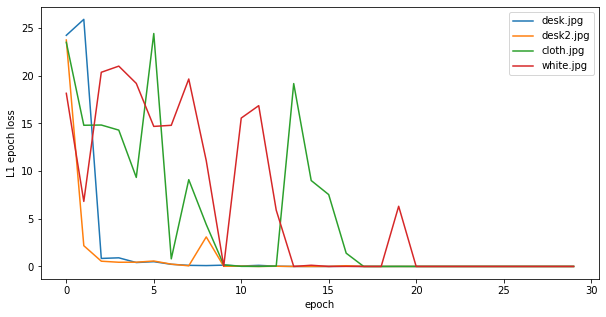

In [25]:
plt.figure(figsize=(10, 5))

for i, label in enumerate(labels):
    plt.plot(np.arange(len(l1_loss[i])), l1_loss[i], label=label)
plt.xlabel("epoch")
plt.ylabel("L1 epoch loss")
plt.legend()
plt.show()

# Model interpretation

In [ ]:
# !pip install lime

In [16]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [23]:
explainer = lime_image.LimeImageExplainer()

In [29]:
gen = pt.Generator(n_classes=61, batch_size=1, PREFIX=PREFIX)
gen.initialize(backs[1: 2], images[500: 501], rotate_background=True)

input_data = None
for x in gen:
    input_data = x[0].transpose(1, 2).transpose(2, 3)
    break

print(input_data.shape)

torch.Size([1, 224, 224, 3])


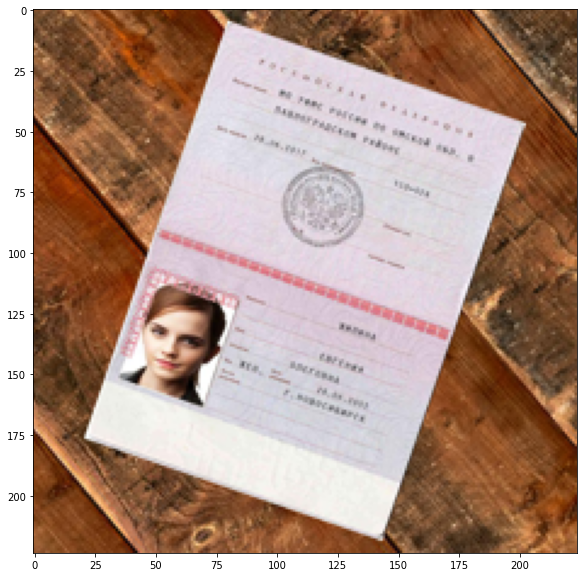

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(input_data[0] / 255)

In [31]:
explanation = explainer.explain_instance(input_data[0].numpy().astype(np.double), model.batch_predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

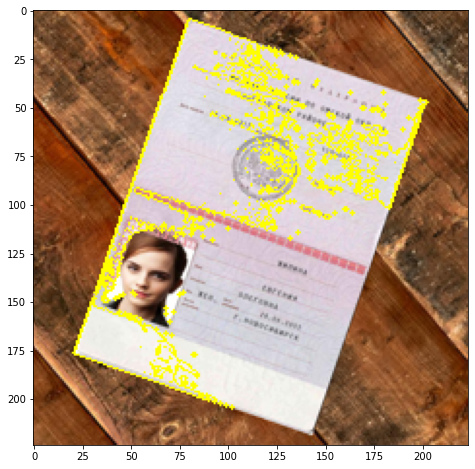

In [32]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 255.0, mask)
plt.figure(figsize=(8, 8))
plt.imshow(img_boundry1)

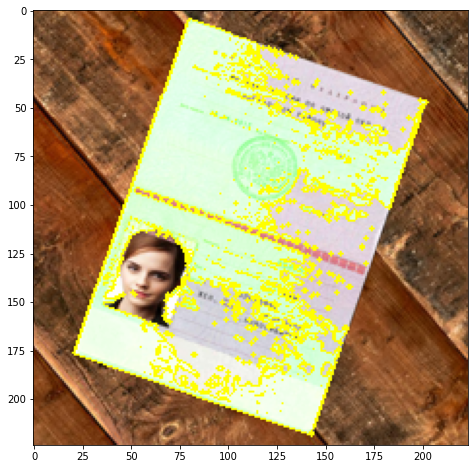

In [33]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure(figsize=(8, 8))
plt.imshow(img_boundry2)